# QAOA with Amazon Braket Hybrid Jobs and PennyLane

In this tutorial, we use PennyLane within Amazon Braket Hybrid Jobs to run the Quantum Approximate Optimization Algorithm (QAOA) on a Max-Cut problem.

## Learning outcomes
* Use pre-built PennyLane containers in Braket Jobs
* Set QAOA hyperparameters 
* Choose PennyLane backend (TensorFlow, PyTorch)
* Use checkpoints for Braket Jobs

## QAOA background 

QAOA is a variational algorithm that uses parameterized quantum circuits to evaluate a classical cost function given by a binary optimization problem; the circuit parameters are iteratively adjusted to minimize the cost function. The QAOA algorithm itself has different settings, such as circuit depth ($p$). In analogy to machine learning, these input settings are commonly referred to as _hyperparameters_. In the following, we show how to setup the problem, prepare input data and run QAOA using Braket Jobs.

For more information about QAOA and PennyLane, see [this example notebook](../pennylane/2_Graph_optimization_with_QAOA.ipynb) or [this PennyLane tutorial](https://pennylane.ai/qml/demos/tutorial_qaoa_intro.html).

## Problem setup

A Max Cut problem is the problem to find a cut in a graph that maximizes the number of edges between the two parts after the cut. It has applications in theoretical physics and in combinatorial optimizations. To get started, we first create and visualize a random graph for the Max-Cut problem with <code>networkx</code> package. Feel free to adjust the number of nodes, <code>n</code>, and number of edges, <code>m</code> as part of your experiments.

In [1]:
import time

import networkx as nx
from braket.aws import AwsQuantumJob, AwsSession
from braket.jobs.image_uris import Framework, retrieve_image
import matplotlib.pyplot as plt

%matplotlib inline

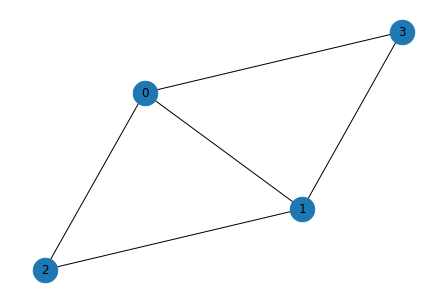

In [2]:
# We generate a random graph with num_nodes nodes and num_edges edges to run Max Cut on.
# num_nodes is the number of nodes in your graph, each represented by one qubit. 
# Caution: Circuit runtimes will scale exponentially with num_nodes
num_nodes = 4
num_edges = 5
seed = 40

graph = nx.gnm_random_graph(num_nodes, num_edges, seed=seed)

# Draw the graph
positions = nx.spring_layout(graph, seed=seed)
nx.draw(graph, with_labels=True, pos=positions, node_size=600)

## Prepare input data
We will prepare the optimization problem we want to solve, represented by the so-called Ising matrix, as the input data for the Braket Job. This best practice helps us decouple our problem definition from our algorithm code. If we want to solve another instance of this problem type, all we need to do is to point a new job to the new input data. The input data can be specified by either a path to a local file, or an Amazon S3 path that points to the data. For this example, we will create a file in the local directory encoding the problem graph.

In [3]:
input_file_path = "input-data.adjlist"
nx.write_adjlist(graph, input_file_path)

## Specify hyperparameters and configurations

"The hyperparameters can be passed in when you create your job, through the keyword argument <code>hyperparameters</code>. It usually includes all the algorithm settings you might want to adjust between runs to tailor your algorithm to the problem. This includes, for instance, the optimizer to use and its learning rate, the number of iterations, or the number of shots per device execution. 

In [8]:
# Pick 'autograd', 'tf', or 'torch'. Autograd is base PennyLane
interface = "autograd"

# Specify device that the job will primarily be targeting
# device_arn = "arn:aws:braket:::device/quantum-simulator/amazon/sv1"
device_arn="arn:aws:braket:eu-west-2::device/qpu/oqc/Lucy"
# device_arn="arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-1"
# device_arn="arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-1"

hyperparameters = {
    # Number of tasks per iteration = 2 * (num_nodes + num_edges) * p + 1
    "p": "2",
    "seed": str(seed),
    # Maximum number of simultaneous tasks allowed
    "max_parallel": "1",
    # Number of total optimization iterations, including those from previous checkpoint (if any)
    "num_iterations": "6",
    # Step size / learning rate for gradient descent
    "stepsize": "0.1",
    # Shots for each circuit execution
    "shots": "1000",
    "interface": interface,
}

For this demo, we submit the job to Braket-Gamma. To achieve this we set up an AWS session with Gamma endpoint.

In [9]:
import boto3
from braket.aws import AwsSession

region_name = "eu-west-2"
# endpoint_url = "https://5sk8cnl96i.execute-api.eu-west-2.amazonaws.com/Prod"
# endpoint_url = "https://braket-gamma.eu-west-2.amazonaws.com"
# endpoint_url = "https://braket.eu-west-2.amazonaws.com"

# region_name = "us-west-1"
# endpoint_url = "https://braket-gamma.us-west-1.amazonaws.com"
# endpoint_url = "https://braket.us-west-1.amazonaws.com"

# braket_client = boto3.client("braket", region_name=region_name, endpoint_url=endpoint_url)
braket_client = boto3.client("braket", region_name=region_name)
aws_session = AwsSession(braket_client=braket_client)

Braket Jobs comes with three pre-configured container environments. The base container does not include PennyLane, so we need to use one of the two PennyLane containers: TensorFlow or PyTorch.

In [10]:
# region = AwsSession().region

# if interface == "autograd" or interface == "tf":
#     image_uri = retrieve_image(Framework.PL_TENSORFLOW, region_name)
# elif interface == "torch":
#     image_uri = retrieve_image(Framework.PL_PYTORCH, region_name)
image_uri = "292282985366.dkr.ecr.eu-west-2.amazonaws.com/amazon-braket-pytorch-jobs:1.8.1-cpu-py37-ubuntu18.04"

## Algorithm script

The algorithm script we are going to use for solving the Max-Cut problem with QAOA can be found [here](qaoa_source/qaoa_algorithm_script.py).

## Submitting a Braket Job

We have now finished preparing the input data, algorithm script, hyperparameters and other configurations. It's time to submit our Braket Job!

We specify the following arguments to create our job: 

- <code>device</code>: The arn of the Braket simulator or QPU we want to use. It will be stored as an environment variable for the algorithm script.
- <code>source_module</code>: The path to a file or a python module that contains your algorithm script. It will be uploaded to the container for Braket Job execution.
- <code>job_name</code>: A unique string to identify the job. It appears in the Braket Job console and in the job arn.
- <code>image_uri</code>: The path to a Docker container image.
- <code>entry point</code>: The path relative to the source_module. It points to the piece of code to be executed when the Braket Job starts.
- <code>copy_checkpoints_from_job</code>: A string that specifies the job arn whose checkpoint you want to use in the current job. If `None` (default value), no checkpoints will be copied to the current job.
- <code>hyperparameters</code>: The Python dictionary containing the hyperparameter names and values (as strings).
- <code>input_data</code>: A dictionary that maps channel names to either a file location in the local environment or a path to S3. We can also specify only a file location, in which case the channel name is treated as "input".
- <code>wait_until_complete</code>: If True, the function call will wait until the Braket Job is completed, and will additionally print logs to the local console. Otherwise, it will run asynchronously. Defaults to False.

In [11]:
job = AwsQuantumJob.create(
    device=device_arn,
    source_module="qaoa",
    job_name="qaoa-job-" + interface + "-" + str(int(time.time())),
    image_uri=image_uri,
    # Relative to the source_module
    entry_point="qaoa.qaoa_algorithm_script",
    copy_checkpoints_from_job=None,
    # general parameters
    hyperparameters=hyperparameters,
    input_data={"input-graph": input_file_path},
    wait_until_complete=True,
    aws_session=aws_session
)

Initializing Braket Job: arn:aws:braket:eu-west-2:537332306153:job/qaoa-job-autograd-1645757412
......................................
2022-02-25 02:53:46,141 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-02-25 02:53:46,142 sagemaker-training-toolkit INFO     Failed to parse hyperparameter interface value autograd to Json.
Returning the value itself
2022-02-25 02:53:49,172 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-02-25 02:53:49,173 sagemaker-training-toolkit INFO     Failed to parse hyperparameter interface value autograd to Json.
Returning the value itself
2022-02-25 02:53:49,184 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-02-25 02:53:49,185 sagemaker-training-toolkit INFO     Failed to parse hyperparameter interface value autograd to Json.
Returning the value itself
2022-02-25 02:53:49,195 sagemaker-training-toolkit INFO     Invoking user script
Trainin

  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=8e2fb653eab4e09aafc248cf4e1daed0ba38b9df972f7fc29b3f69b9e04c3d8b
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built autograd future
Processing /opt/ml/code/customer_code/extracted/qaoa/amazon-braket-schemas-python-staging-oqc-without-qasm
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for amazon-braket-schemas: filename=amazon_braket_schemas-1.8.0.dev0-py3-none-any.whl size=76781 sha256=5307452ce4e4f41eeb6285d88900997c5bedba8a9f48ecfe01d9c0c86e34cb76
  Stored in directory: /root/.cache/pip/wheels/c1/59/d4/7047a80318fe5e7c148ad3b41742

  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for amazon-braket-sdk: filename=amazon_braket_sdk-1.14.1.dev0-py3-none-any.whl size=155008 sha256=740d7ffd7dade3e528243abad379314dc65d68a1542568a4b34e453c660cfa0f
  Stored in directory: /root/.cache/pip/wheels/d0/04/3f/01eb6c429714bf2809e19f864e1e92e94f3ff9241863351c3a
Successfully built amazon-braket-sdk
  Attempting uninstall: amazon-braket-sdk
    Found existing installation: amazon-braket-sdk 1.10.0
    Uninstalling amazon-braket-sdk-1.10.0:
      Successfully uninstalled amazon-braket-sdk-1.10.0
environ({'PATH': '/usr/local/openmpi/bin/:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin', 'HOSTNAME': 'ip-10-0-195-111.eu-west-2.compute.internal', 'AMZN_BRAKET_DEVICE_ARN': 

Initial cost: -2.333
Metrics - timestamp=1645757783.6976306; Cost=-2.333; iteration_number=0;
Completed iteration 1
Time to complete iteration: 124.36228513717651 seconds
Cost at step 1: -2.3529999999999998
Metrics - timestamp=1645757897.6809778; Cost=-2.3529999999999998; iteration_number=1;
Completed iteration 2
Time to complete iteration: 113.98085451126099 seconds
Cost at step 2: -2.345
Metrics - timestamp=1645758012.9435496; Cost=-2.345; iteration_number=2;
Completed iteration 3
Time to complete iteration: 115.26183485984802 seconds
Cost at step 3: -2.351
Metrics - timestamp=1645758127.256694; Cost=-2.351; iteration_number=3;
Completed iteration 4
Time to complete iteration: 114.31234073638916 seconds
Cost at step 4: -2.318
Metrics - timestamp=1645758244.837883; Cost=-2.318; iteration_number=4;
Completed iteration 5
Time to complete iteration: 117.5804705619812 seconds
Cost at step 5: -2.347
Metrics - timestamp=1645758364.117128; Cost=-2.347; iteration_number=5;
Completed iteration

## View results

After the job is completed, we can view the result and the metric we defined in the algorithm script.

In [7]:
# job = AwsQuantumJob("arn:aws:braket:us-west-2:537332306153:job/qaoa-job-autograd-1645155074")
# job = AwsQuantumJob("arn:aws:braket:eu-west-2:537332306153:job/qaoa-job-autograd-1645757412") # Lucy

In [12]:
%%time
# This cell should take 7-8  minutes
job_result = job.result()
print(job_result)

{'params': [[0.034576870280802856, 0.058653660401118614], [-0.043214651225132475, 0.046073051847893454]], 'cost': -2.306}
CPU times: user 83.8 ms, sys: 12.4 ms, total: 96.2 ms
Wall time: 1.51 s


In [13]:
# May need to wait a bit before metrics show up. If metrics aren't there, run a bit later
# time.sleep(20)
print(job.metrics())

{'timestamp': [1645758367.172416, 1645758364.117128, 1645758244.837883, 1645758127.256694, 1645758012.9435496, 1645757897.6809778, 1645757783.6976306], 'Cost': [-2.306, -2.347, -2.318, -2.351, -2.345, -2.3529999999999998, -2.333], 'iteration_number': [6.0, 5.0, 4.0, 3.0, 2.0, 1.0, 0.0]}


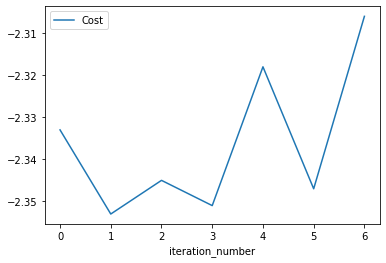

In [16]:
# A demonstration of plotting the metrics
import pandas as pd
from matplotlib.ticker import MaxNLocator

metrics_data = job.metrics()

if metrics_data: 
    df = pd.DataFrame(job.metrics())

    ax = plt.figure().gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    figure = df.plot(x="iteration_number", y="Cost", ax=ax)
else:
    print("Wait for metrics to populate and re-run the cell.")

In [20]:
from qaoa.qaoa_model import qaoa_model
params = job_result['params']
circuit = qaoa_model(device_arn, hyperparameters, graph)
output = circuit(params)

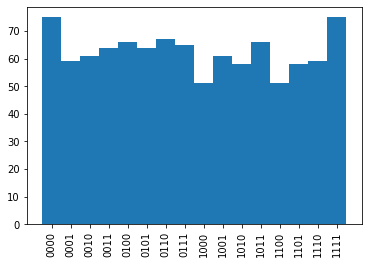

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def bitstring_to_int(bit_string_sample):
    bit_string = "".join(str(bs) for bs in bit_string_sample)
    return int(bit_string, base=2)

samples = [bitstring_to_int(x) for x in output]

bins = np.arange(0, 2**num_nodes+1) - 0.5
xticks = range(0, 2**num_nodes)
xtick_labels = list(map(lambda x: format(x, "04b"), xticks))

plt.hist(samples, bins=bins)
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.show()

## Summary

In this tutorial, we set up a Max-Cut problem with a random graph using PennyLane. We saved the graph to a local file and provided it as input data to our Braket Job, and used the pre-built PennyLane container image to run it. Variables that are required for the training process and the optimizer are passed as hyperparameters. The result is retrieved after the QAOA algorithm is completed. Lastly, we demonstrated how to use checkpoints to save and load training progress of a job.